In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [15]:
np.random.seed(42)

DATA_DIR = r"C:\Users\aparn\Downloads\wine+quality"

if os.path.isdir(DATA_DIR):
    os.chdir(DATA_DIR)
    print("Working directory:", os.getcwd())
else:
    print(f"Warning: {DATA_DIR} not found. Using {os.getcwd()}")


Working directory: C:\Users\aparn\Downloads\wine+quality


In [16]:
required_files = ["winequality-red.csv", "winequality-white.csv"]

for f in required_files:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing file: {f}")


In [17]:
red = pd.read_csv("winequality-red.csv", sep=";")
white = pd.read_csv("winequality-white.csv", sep=";")

red["type"] = 0
white["type"] = 1

data = pd.concat([red, white], ignore_index=True)
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [18]:
X = data.drop(columns=["quality"]).values.astype(np.float64)
y = data["quality"].values.astype(np.float64).reshape(-1, 1)

X.shape, y.shape


((6497, 12), (6497, 1))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

X_train.shape, X_test.shape


((5197, 12), (1300, 12))

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
class MLP:
    def __init__(self, layer_sizes, activations, seed=42):
        assert len(layer_sizes) - 1 == len(activations)
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.params = {}
        rng = np.random.RandomState(seed)

        for i in range(len(layer_sizes) - 1):
            n_in, n_out = layer_sizes[i], layer_sizes[i + 1]
            limit = np.sqrt(6 / (n_in + n_out))
            self.params[f"W{i+1}"] = rng.uniform(-limit, limit, (n_in, n_out))
            self.params[f"b{i+1}"] = np.zeros((1, n_out))

    def _activation(self, x, name):
        if name == "relu":
            return np.maximum(0, x)
        elif name == "tanh":
            return np.tanh(x)
        elif name == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif name == "linear":
            return x
        else:
            raise ValueError("Unknown activation")

    def _activation_deriv(self, x, name):
        if name == "relu":
            return (x > 0).astype(float)
        elif name == "tanh":
            t = np.tanh(x)
            return 1 - t**2
        elif name == "sigmoid":
            s = 1 / (1 + np.exp(-x))
            return s * (1 - s)
        elif name == "linear":
            return np.ones_like(x)
        else:
            raise ValueError("Unknown activation")

    def forward(self, X):
        caches = {"zs": [], "as": []}
        a = X
        caches["as"].append(a)

        for i in range(len(self.layer_sizes) - 1):
            z = a @ self.params[f"W{i+1}"] + self.params[f"b{i+1}"]
            caches["zs"].append(z)
            a = self._activation(z, self.activations[i])
            caches["as"].append(a)

        return a, caches

    def compute_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, caches, y_pred, y_true):
        grads = {}
        m = y_true.shape[0]
        dA = (2.0 / m) * (y_pred - y_true)

        for i in reversed(range(len(self.layer_sizes) - 1)):
            z = caches["zs"][i]
            a_prev = caches["as"][i]
            dz = dA * self._activation_deriv(z, self.activations[i])

            grads[f"dW{i+1}"] = a_prev.T @ dz
            grads[f"db{i+1}"] = np.sum(dz, axis=0, keepdims=True)
            dA = dz @ self.params[f"W{i+1}"].T

        return grads

    def update_params(self, grads, lr):
        for i in range(1, len(self.layer_sizes)):
            self.params[f"W{i}"] -= lr * grads[f"dW{i}"]
            self.params[f"b{i}"] -= lr * grads[f"db{i}"]

    def predict(self, X):
        y_pred, _ = self.forward(X)
        return y_pred


In [22]:
n_features = X_train_scaled.shape[1]

layer_sizes = [n_features, 64, 32, 1]
activations = ["relu", "relu", "linear"]

mlp = MLP(layer_sizes, activations, seed=42)


In [23]:
epochs = 300
batch_size = 64
lr = 0.01

train_losses = []
val_losses = []

n_samples = X_train_scaled.shape[0]
steps_per_epoch = int(np.ceil(n_samples / batch_size))


In [24]:
for epoch in range(1, epochs + 1):
    perm = np.random.permutation(n_samples)
    X_shuffled = X_train_scaled[perm]
    y_shuffled = y_train[perm]

    epoch_loss = 0.0

    for step in range(steps_per_epoch):
        start = step * batch_size
        end = start + batch_size

        X_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]

        y_pred, caches = mlp.forward(X_batch)
        loss = mlp.compute_loss(y_pred, y_batch)
        epoch_loss += loss * X_batch.shape[0]

        grads = mlp.backward(caches, y_pred, y_batch)
        mlp.update_params(grads, lr)

    epoch_loss /= n_samples
    val_loss = mlp.compute_loss(mlp.predict(X_test_scaled), y_test)

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    if epoch % 25 == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch:3d}/{epochs} | Train MSE: {epoch_loss:.4f} | Val MSE: {val_loss:.4f}")


Epoch   1/300 | Train MSE: 2.9324 | Val MSE: 0.9927
Epoch  25/300 | Train MSE: 0.4519 | Val MSE: 0.4858
Epoch  50/300 | Train MSE: 0.4305 | Val MSE: 0.4688
Epoch  75/300 | Train MSE: 0.4127 | Val MSE: 0.4717
Epoch 100/300 | Train MSE: 0.4004 | Val MSE: 0.4612
Epoch 125/300 | Train MSE: 0.3895 | Val MSE: 0.4549
Epoch 150/300 | Train MSE: 0.3782 | Val MSE: 0.4887
Epoch 175/300 | Train MSE: 0.3734 | Val MSE: 0.4652
Epoch 200/300 | Train MSE: 0.3640 | Val MSE: 0.4752
Epoch 225/300 | Train MSE: 0.3584 | Val MSE: 0.4803
Epoch 250/300 | Train MSE: 0.3514 | Val MSE: 0.4721
Epoch 275/300 | Train MSE: 0.3471 | Val MSE: 0.5278
Epoch 300/300 | Train MSE: 0.3391 | Val MSE: 0.4624


In [25]:
y_test_pred = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

print("Final Test Results")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Final Test Results
MSE  : 0.4624
RMSE : 0.6800
R²   : 0.3739


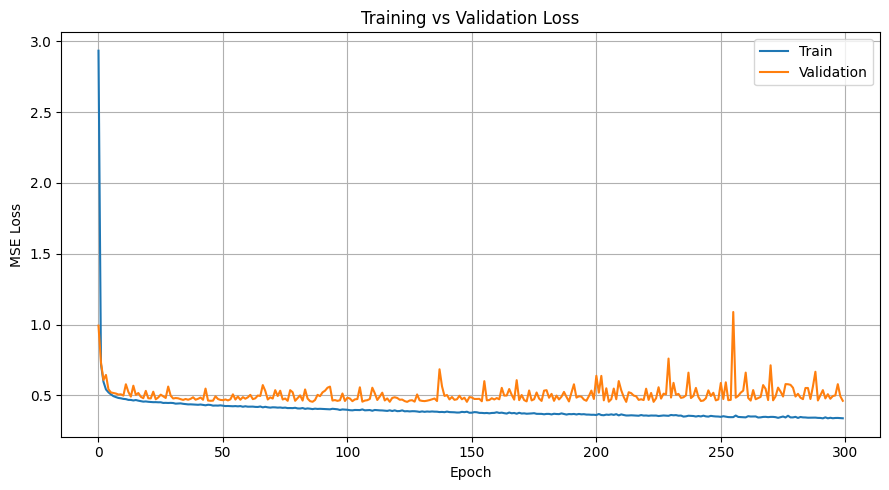

In [26]:
plt.figure(figsize=(9, 5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mlp_loss_curve.png")
plt.show()


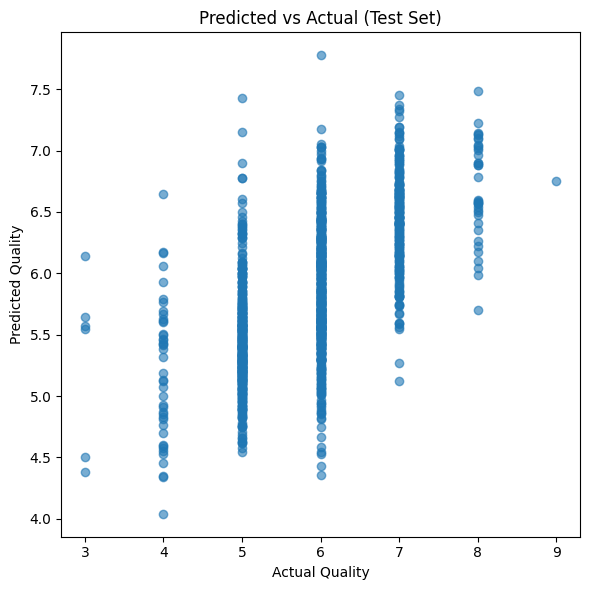

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Predicted vs Actual (Test Set)")
plt.tight_layout()
plt.savefig("mlp_pred_vs_actual.png")
plt.show()


In [28]:
np.savez("mlp_params.npz", **mlp.params)

pred_df = pd.DataFrame({
    "Actual": y_test.ravel(),
    "Predicted": y_test_pred.ravel()
})

pred_df.head(10)


,Actual,Predicted
0,8.0,5.987050
1,5.0,5.123878
2,7.0,7.151999
3,6.0,5.418850
4,6.0,5.629915
5,6.0,6.513226
6,5.0,5.647423
7,6.0,6.059702
8,5.0,4.983915
9,7.0,6.825676


In [29]:
print("Saved files:")
for f in ["mlp_loss_curve.png", "mlp_pred_vs_actual.png", "mlp_params.npz"]:
    print(f, "->", os.path.exists(f))


Saved files:
mlp_loss_curve.png -> True
mlp_pred_vs_actual.png -> True
mlp_params.npz -> True
